# Dataset & References


Dataset: http://www.cs.toronto.edu/~kriz/cifar.html<br>
Reference: https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
import os
from tqdm import tqdm, trange

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 10
epochs = 25
data_augmentation = False

In [3]:
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Taken from cifar10.py from ~/miniconda3/lib/python3.7/site-packages/keras/datasets
# since i have already downloaded the dataset, if not already downloaded then use get_file()

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.datasets.cifar import load_batch
from keras.utils.data_utils import get_file
from keras import backend as K


fpath = './cifar-10-python.tar.gz'

dirname = './cifar-10-batches-py/'
path = dirname

num_train_samples = 50000

x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
y_train = np.empty((num_train_samples,), dtype='uint8')

for i in range(1, 6):
    fpath = os.path.join(path, 'data_batch_' + str(i))
    (x_train[(i - 1) * 10000: i * 10000, :, :, :],
     y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

fpath = os.path.join(path, 'test_batch')
x_test, y_test = load_batch(fpath)

y_train = np.reshape(y_train, (len(y_train), 1))
y_test = np.reshape(y_test, (len(y_test), 1))

if K.image_data_format() == 'channels_last':
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [4]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


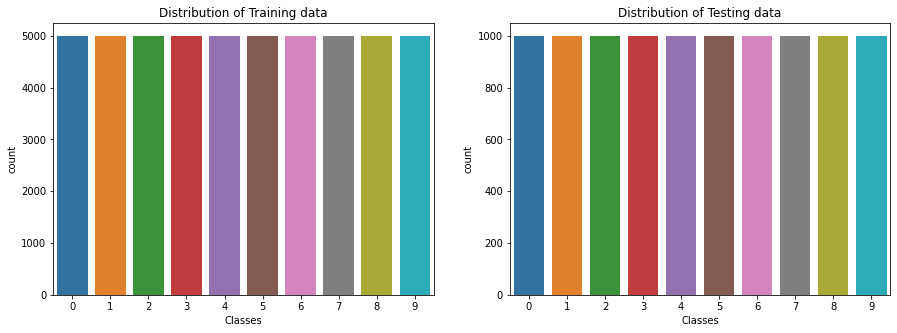

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of Training data')
axs[0].set_xlabel('Classes')

sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32,(3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [8]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [9]:
history = None

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(x_test, y_test), shuffle=True)
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening = False,
        zca_epsilon = 1e-06,
        rotation_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format = None,
        validation_split=0.0  )
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size), epochs=epochs, 
                                  validation_data=(x_test, y_test), workers=4)
    

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 251s 5ms/step - loss: 1.8317 - accuracy: 0.3272 - val_loss: 1.5538 - val_accuracy: 0.4371
Epoch 2/25
50000/50000 [==============================] - 236s 5ms/step - loss: 1.5148 - accuracy: 0.4507 - val_loss: 1.3603 - val_accuracy: 0.5201
Epoch 3/25
50000/50000 [==============================] - 251s 5ms/step - loss: 1.3731 - accuracy: 0.5071 - val_loss: 1.2586 - val_accuracy: 0.5575
Epoch 4/25
50000/50000 [==============================] - 235s 5ms/step - loss: 1.2767 - accuracy: 0.5485 - val_loss: 1.3317 - val_accuracy: 0.5391
Epoch 5/25
50000/50000 [==============================] - 235s 5ms/step - loss: 1.1921 - accuracy: 0.5829 - val_loss: 1.0820 - val_accuracy: 0.6179
Epoch 6/25
50000/50000 [==============================] - 230s 5ms/step - loss: 1.1205 - accuracy: 0.6068 - val_loss: 1.0475 - val_accuracy: 0.6333
Epoch 7/25
50000/50000 [=========

KeyboardInterrupt: 

In [10]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    
    plt.show()
    
print(history.history.keys())

plotmodelhistory(history)

AttributeError: 'NoneType' object has no attribute 'history'

In [11]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: ', scores[0])
print('Test Accuracy: ', scores[1])

10000/10000 [==============================] - 19s 2ms/step
Test Loss:  0.7767711566925048
Test Accuracy:  0.7332000136375427


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax=plt.gca()
        
    im = ax.imshow(data, **kwargs)
    
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va=bottom)
    
    ax.set_xticks(np.arrange(data.shape[1]))
    ax.set_yticks(np.arrange(data.shape[0]))
    
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar